# Задание по теме "Улучшение качества модели"
Взять boston house-prices datase (sklearn.datasets.load_boston) и сделать тоже самое для задачи регрессии (попробовать разные алгоритмы, поподбирать параметры, вывести итоговое качество)

**Кулешов Иван AML-14**

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Функции для исследования

In [ ]:
# Для поиска выбросов будем использовать boxplot, pairplot
def get_boxplot(X, columns=None):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.boxplot(x=X[i])
    plt.show()
  pass  

def get_pairplot(X, columns=None):
  if columns is None:
    columns = X.columns

  sns.pairplot(X[columns])
  pass

def get_hist(X, columns=None, bins='auto'):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.histplot(x=X[i], bins=bins)
    plt.grid()
    plt.show()
  pass

def get_heatmap(X, columns=None, target=None, thres=0.5):
  if columns is None:
    columns = X.columns

  # если задана целевая переменная - вывести только те переменные
  # из columns, у которых корреляция с целевой выше порога 
  if target is not None:
    columns = X[columns].corr().index[abs(X[columns].corr()[target]) > thres]
 
  sns.heatmap(X[columns].corr(), cmap='coolwarm', annot = True, )
  pass

# Решение

## Работа с датасетом

Воспользуемся результатами обработки датасета, выполненными в предыдущем домашнем задании:

In [ ]:
from sklearn.datasets import load_boston
data = pd.read_csv(load_boston()['filename'], skiprows=1)

In [ ]:
data.head()

CRIM    ZN  INDUS  CHAS    NOX  ...  TAX  PTRATIO       B  LSTAT  MEDV
0  0.00632  18.0   2.31     0  0.538  ...  296     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07     0  0.469  ...  242     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07     0  0.469  ...  242     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18     0  0.458  ...  222     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18     0  0.458  ...  222     18.7  396.90   5.33  36.2

[5 rows x 14 columns]

Убираем выбросы

In [ ]:
data = data[data['MEDV'] < 50.0]
data.shape

(490, 14)

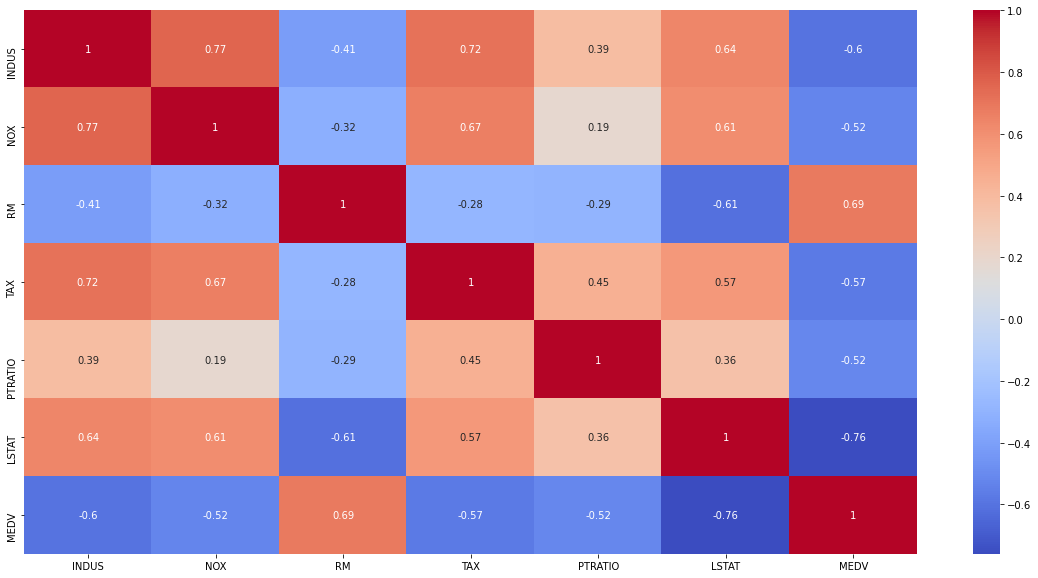

In [ ]:
plt.figure(figsize=(20, 10))
get_heatmap(data, target='MEDV')

оставляем только переменные, у которых корреляция с целевой переменной выше 0.5:

In [ ]:
data = data[['LSTAT', 'RM', 'INDUS', 'TAX', 'NOX', 'PTRATIO', 'MEDV']]

Добавим в наш датасет две новых переменных:
- произведение RM * LSTAT
- отношение RM / LSTAT

и уберем исходные переменные RM, LSTAT:

In [ ]:
data['mult'] = data['RM'] * data['LSTAT']
data['divide'] = data['RM'] / data['LSTAT']
data.drop(['RM','LSTAT'], axis = 1, inplace=True)

## Разбиение и нормирование

Разобьем на обучающую и тестовую выборку, сделаем нормирование и расчитаем точность регрессии

In [ ]:
y = data['MEDV']
X = data.drop('MEDV', axis=1)

! В параметрах метода train_test_split стоит shuffle=True, что означает случайное перемешивание, и значит, в случае повторного запуска расчета все числовые параметры, которые я ниже описываю - будут другими.

In [ ]:
# разбиваем данные на train и на test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.3)  

In [ ]:
# делаем нормирование
from sklearn.preprocessing import StandardScaler
stX = StandardScaler()
X_train.loc[:,:] = stX.fit_transform(X_train)
X_test.loc[:,:] = stX.transform(X_test)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((343, 6), (343,), (147, 6), (147,))

## Базовые модели регрессии

Сначала определим наши модели, обучим на train выборке каждую, и получим точность (score) для тестовой выборки. Эти результаты станут ориентиром для сравнения результатов этих же моделей на тестовой выборке после подбора параметров.

In [ ]:
# Возьмем следующие модели
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, HuberRegressor, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Словарь с моделями
models = {
    '1. svr': SVR(),
    '2. knn': KNeighborsRegressor(),
    '3. lasso': Lasso(),
    '4. ridge': Ridge(),
    '5. huber': HuberRegressor(),
    '6. elastic': ElasticNet(),
    '7. tree': DecisionTreeRegressor(),
    '8. random_tree': RandomForestRegressor()
}

In [ ]:
# чтобы не городить много однотипных вызовов функций, сделаем в генераторе 
gen_base = {name_model:
            models[name_model].fit(X_train,y_train).score(X_test,y_test) for name_model in models}
gen_base

{'1. svr': 0.6949050772878094,
 '2. knn': 0.7938907624452335,
 '3. lasso': 0.7159046691810127,
 '4. ridge': 0.7507808469215699,
 '5. huber': 0.7418120572808373,
 '6. elastic': 0.6905601994757942,
 '7. tree': 0.6974784788661386,
 '8. random_tree': 0.8165763090253466}

Вывод: лучшие результаты на тестовой выборке показали модели с параметрами по умолчанию:
1. модель случайного леса, scrore = 0.817
2. модель к-соседей, score = 0.794

## Оптимизация параметров моделей

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

Определим список параметров для перебора для каждой модели:

In [ ]:
param_svr = {'kernel':['linear','poly', 'rbf', 'sigmoid'],
             'degree':[2,3],
             'gamma': ['scale', 'auto'],
             'shrinking': [True, False],
             'epsilon': [0.001, 0.2, 20]
             }

param_knn = {'n_neighbors': [1, 3, 5, 7, 9],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'weights': ['uniform','distance'],
              'p': [1, 2]
              }

param_lasso = {'alpha': np.logspace(-7, 2, 100),
                'random_state': [42]
                }

param_ridge = {'alpha': np.logspace(-7, 2, 100),
               'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
               'random_state': [42]
               }

param_huber = {'alpha': np.logspace(-7, 2, 100),
               'epsilon': np.linspace(1, 2, 50)
               }

param_elastic = {'alpha': np.logspace(-5, 2, 100),
                 'l1_ratio': np.linspace(0, 1, 50),
                 'max_iter': [5000],
                 'tol': [0.00001]
                 }


param_tree = {'criterion': ["mse", "friedman_mse", "mae"],
              'splitter': ["best", "random"], 
              'max_depth': range(1,16), 
              'min_samples_split': [2, 3, 5, 7, 10, 15, 25],
              'min_samples_leaf': [1, 2, 4, 8, 10, 12, 16],
              'max_features': [1, 2, 3, 4]
              }

param_rf = {
    'n_estimators': [5, 10, 20, 40, 50, 100],
    'criterion': ["mse", "friedman_mse", "mae"],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 10, 12, 16],
    'oob_score': [True, False]
}

In [ ]:
# Словарь с моделями и их параметрами
models = {
    '1. svr': [SVR(), param_svr],
    '2. knn': [KNeighborsRegressor(), param_knn],
    '3. lasso': [Lasso(), param_lasso],
    '4. ridge': [Ridge(), param_ridge],
    '5. huber': [HuberRegressor(), param_huber],
    '6. elastic': [ElasticNet(), param_elastic],
    '7. tree': [DecisionTreeRegressor(), param_tree],
    '8. random_tree': [RandomForestRegressor(), param_rf]
}

In [ ]:
# метод разбиения на фолды, выберем 5
cv = KFold(n_splits=5)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

!Осторожно, расчет занимает 20 минут

In [ ]:
# формируем генератором словарь обученных GridSearch для каждой модели
grids = {x:
       GridSearchCV(models[x][0], 
                    models[x][1], 
                    scoring='r2', 
                    cv=cv).fit(X_train, y_train) for x in models}

Формируем генератором словарь, где для каждой модели будет содержаться:
- лучший скоринг для сочетания параметров
- скоринг (использую r2) для тестовой выборки

In [ ]:
gen_grid = {name_model:
            [grids[name_model].best_score_,
             grids[name_model].best_estimator_.score(X_test,y_test)] for name_model in grids}

for i in gen_grid:
  gr = gen_grid[i]
  print(f'модель={i} лучший скор при кросс-валидации={gr[0]:.5f} скор на тесте={gr[1]:.5f}')

модель=1. svr лучший скор при кросс-валидации=0.72803 скор на тесте=0.73893
модель=2. knn лучший скор при кросс-валидации=0.79507 скор на тесте=0.82700
модель=3. lasso лучший скор при кросс-валидации=0.73356 скор на тесте=0.75127
модель=4. ridge лучший скор при кросс-валидации=0.73387 скор на тесте=0.75031
модель=5. huber лучший скор при кросс-валидации=0.73661 скор на тесте=0.74509
модель=6. elastic лучший скор при кросс-валидации=0.73403 скор на тесте=0.75030
модель=7. tree лучший скор при кросс-валидации=0.77845 скор на тесте=0.74487
модель=8. random_tree лучший скор при кросс-валидации=0.82516 скор на тесте=0.81696


In [ ]:
# еще раз базовое решение
gen_base

{'1. svr': 0.6949050772878094,
 '2. knn': 0.7938907624452335,
 '3. lasso': 0.7159046691810127,
 '4. ridge': 0.7507808469215699,
 '5. huber': 0.7418120572808373,
 '6. elastic': 0.6905601994757942,
 '7. tree': 0.6974784788661386,
 '8. random_tree': 0.8165763090253466}

# Выводы

Как видно, все алгоритмы улучшили свою точность на тестовой выборке после подбора лучшего сочетания параметров с помощью GridSearch, кроме моделей Ridge и Случайного леса, которые снизились незначительно.

Самыми перспективными остались модели случайного леса и метода ближайшего соседа.

Самым интересным наблюдением считаю следующий момент: на кросс-валидации модель Решающих деревьев показала результат 0.77845, что является третьим результатом после указанных выше моделей-лидеров, однако, итоговая точность на тестовой выборке сильно просела. Это очень поучительный опыт, ведь кросс-валидации считается хорошим приёмом для отбора моделей друг от друга в качестве перспективы дальнейшей работы, тюнинга параметров и т.д. Как видно, не всегда это может приводить к хорошим результатам.



# Реализуем стекинг

Было бы, пожалуй, неплохо для полученных моделей реализовать стекинг, и посмотреть, улучшается ли качество:

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ARDRegression

Итоговым регрессором трех моделей будет модель ARDRegression.

In [ ]:
# список из моделей с лучшими параметрами, которые расчитаны в GridSearch
reg_data = [(name_model, grids[name_model].best_estimator_) for name_model in grids]

In [ ]:
# Настраиваем стекинг-регрессор
regressor = StackingRegressor(estimators=reg_data,
    final_estimator=ARDRegression(), 
    cv=10)

In [ ]:
# обучение регрессора, без подбора  параметров
regressor.fit(X_train, y_train)
regressor.final_estimator_

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)

И итоговый срок:

In [ ]:
regressor.score(X_test, y_test)

0.8398353280503186

**Финальный вывод:** лучшая модель после подбора параметров -  метод ближайшего соседа дала точность = 0.82700.

Реализованный стекинг на восьми моделях дал в итоге 0.83983, тем самым ещё раз подтвердив свою эффективность как приёма в машинном обучении.